In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from src.utils import *
import src.prompt as prompt
from src.data_loader import load_spatial_data_csv
import subprocess
import json


import google.generativeai as genai
import pickle

## Cell Type Marker Genes

In [3]:
# optional
representetive_gene_list = ["Flt1", "Mgp", "Bgn", "Mylk", "Aqp4", "Rorb", "Cxcl14", "Pcdhgc3", "Ctgf", "Mog", "Enpp2", "Tpbg", "Tcerg1l",
"Reln", "Pnoc", "Gad1", "Gad2", "Ndnf", "Vip", "Synpr", "Cux2", "Nos1", "Npy", "Lhx6", "Rbp4", "Pcdhgc4",
"Sema3e", "Sema3c", "Sst", "Syt6", "Sla", "Pcp4", "Foxp2"]  # cell type marker genes


## Input Files:
 - data.csv: Main expression data file containing gene expression values (cell * genes)
 - celltype.csv: Cell type annotations for each cell
 - pos.csv: Spatial coordinates (x,y) for each cell
 - (optional) domain.csv: Domain/niche labels for each cell


### Configuration File Description

The configuration file is a YAML file that defines parameters for spatial transcriptomics analysis using large language models. Here's a breakdown of each parameter:

#### Data and Input Parameters
- **`data_name`**: String identifier for the dataset (e.g., "BZ5")
- **`r`**: Float value representing the spatial radius threshold for defining cell neighborhoods (e.g., 700)
- **`tissue_region`**: String describing the tissue/region being analyzed (e.g., "mPFC region of mice")
- **`celltype_name`**: Column name in the data containing cell type annotations (e.g., "cell_type")
- **`pos_name`**: List of column names for spatial coordinates (e.g., ["x", "y"])
- **`name_truth`**: Optional column name for ground truth labels (e.g., "niche_truth")

#### Model Configuration
- **`model_type`**: String specifying the analysis approach (e.g., "zeroshot_end2end")
- **`gpt_model`**: OpenAI model to use (e.g., "gpt-4o-mini")
- **`openai_url`**: API endpoint for OpenAI requests (default: "/v1/chat/completions")

#### Graph and Feature Parameters
- **`Graph_type`**: Type of features to include in analysis:
  - `"count"`: Only cell type counts
  - `"countPlusGenes"`: Cell type counts plus gene expression
  - `"GeneOnly"`: Only gene expression data
- **`minimal_f`**: Minimal frequency threshold for cell types in neighborhoods (float, e.g., 0)
- **`top_n`**: Number of top features/genes to consider (int, e.g., 10)
- **`minimal_gene_threshold`**: Minimum gene expression threshold (float, default: 0.0)

#### Prompt Engineering Parameters
- **`with_negatives`**: Boolean indicating whether to include negative examples in prompts
- **`with_numbers`**: Boolean indicating whether to include quantitative information (frequencies/expression levels)
- **`with_CoT`**: Boolean for Chain-of-Thought prompting (default: false)
- **`use_full_name`**: Boolean for using full cell type names vs. abbreviations
- **`with_self_type`**: Boolean for including the cell's own type in neighborhood description
- **`with_region_name`**: Boolean for including tissue region information in prompts
- **`with_domain_name`**: Boolean for including domain-specific terminology
- **`oneshot_prompt`**: String containing few-shot example prompts (empty by default)
- **`system_prompt`**: String containing system-level instructions for the model (empty by default)

#### Output and Execution Parameters
- **`output_type`**: Type of output expected (e.g., "niche")
- **`confident_output`**: Boolean indicating whether to extract confidence scores from outputs
- **`replicate`**: String suffix for distinguishing multiple runs (e.g., "_testgeneonly")
- **`prototype_p`**: Float parameter for prototype-based analysis (default: 0.0)



In [4]:
config = load_config("model_config/config_zeroshot_example.yaml")

# for data with both cell type and representetive_gene_list
if config.Graph_type == "countPlusGenes":
    prompt_func = prompt.zeroshot_celltype_geneorder
else:
    prompt_func = prompt.zeroshot_celltype


## Domain Mapping

Defines the spatial microenvironments that cells can belong to, serving as the target classification space.

- **Keys**: Numerical identifiers corresponding to spatial regions in the domain.csv. If no domain.csvm the Keys doesn't matter.
- **Values**: Human-readable microenvironment names
- **Usage**: Constrains LLM output to valid categories and provides spatial context

## Cell Names Mapping

Translates abbreviated cell type identifiers into full descriptive biological names.
- **Keys**: Short identifiers from the dataset
- **Values**: Full biological names with functional/spatial information
- **Control**: Applied when `config.use_full_name = True`

In [7]:
# potential niches exist in the data
domain_mapping = {1 : "Layer 1", 2 : "Layer 2/3", 3 : "Layer 5", 4 : "Layer 6"}
config.domain_mapping = domain_mapping

# optional, if you want to map the cell type to a more specific name
cell_names_mapping = {'Astro': 'Astrocytes',
 'Endo': 'Endothelial cells',
 'L5-1': 'Layer 5 pyramidal neuron subtype 1',
 'Lhx6': 'Lhx6-expressing interneurons',
 'NPY': 'Neuropeptide Y-expressing interneurons',
 'Oligo': 'Oligodendrocytes',
 'Reln': 'Reelin-expressing cells',
 'SST': 'Somatostatin-expressing interneurons',
 'Smc': 'Smooth muscle cells',
 'VIP': 'Vasoactive intestinal peptide-expressing interneurons',
 'eL2/3': 'Excitatory neuron layer 2/3',
 'eL5-2': 'Excitatory neuron layer 5 subtype 2',
 'eL5-3': 'Excitatory neuron layer 5 subtype 3',
 'eL6-1': 'Excitatory neuron layer 6 subtype 1',
 'eL6-2': 'Excitatory neuron layer 6 subtype 2'}
config.cell_names_mapping= cell_names_mapping

## Input files
 - data.csv: Main expression data file containing gene expression values (cell * genes)
 - celltype.csv: Cell type annotations for each cell
 - pos.csv: Spatial coordinates (x,y) for each cell
 - (optional) domain.csv: Domain/niche labels for each cell

In [ ]:
# --- Load data ---
data_path = f"example_data/{config.data_name}/"


# Load data using the new function
adata = load_spatial_data_csv(
    data_path=data_path,
    main_data_file="data.csv",
    celltype_file="celltype.csv", 
    pos_file="pos.csv",
    domain_file="domain.csv",
    config=config,
    truth_column_name=config.name_truth,
    index_col=0,
    first_column_names=True
)

# clean the cell ID to save token
# Rename the obs_names of adata
adata.obs_names = [f'cell_{i}' for i in range(len(adata.obs_names))]

# %%
# Prepare neighbor data using the new function
neighbor_normalized_df, neighbor_normalized_df_genes, adj_matrix = prepare_neighbor_data(
    adata, config, representetive_gene_list
)

## Remove redundent cells

The prompts of some cells may be identical. Therefore, remove rudundent cells can save calculation.

In [6]:
# shorten the prompt
unique_indices, idx_mapping, inverse_mapping = get_unique_prompts(
    neighbor_normalized_df, config, prompt_func, df_extra=neighbor_normalized_df_genes)

Generating prompts for each row...


100%|██████████| 1049/1049 [00:00<00:00, 8276.79it/s]

Reduced from 1049 rows to 1034 unique prompts


## Use OpenAI batch API
!!
If use cell type only, change df_extra to None
!!


 `generate_json_end2end` Function
This function prepares data for OpenAI's Batch API by:
- Taking a DataFrame of neighbor cell data and splitting it into manageable batches
- Converting each batch into JSON files formatted according to OpenAI's batch API specification
- Each JSON line contains a chat completion request with:
  - Custom ID for tracking
  - System and user prompts generated by the provided `prompt_func`
  - Model configuration and token limits
- Saves these JSON files to `./batch_json/{data_name}_{model_type}/` directory

 `submit_end2end.py` Script
This script handles the submission and retrieval of batch jobs:
- Reads the JSON files created by `generate_json_end2end`
- Submits each file to OpenAI's Batch API endpoint
- Downloads completed results and saves them as text files in `./batch_results/{data_name}_{model_type}/`

**Workflow**: The functions work together to enable large-scale processing of spatial transcriptomics data through OpenAI's API - `generate_json_end2end` prepares the requests, and `submit_end2end.py` handles the API communication and result collection.


In [ ]:
# batch run with openai api
generate_json_end2end(neighbor_normalized_df.iloc[unique_indices], 
                      config, 
                      prompt_func, 
                      df_extra=neighbor_normalized_df_genes.iloc[unique_indices], 
                      batch_size = 5000,
                      max_completion_tokens = 512,  # key to control the cost, expecially for o3-mini
                      n_rows = 1)

cmd = f"nohup python -u src/submit_end2end.py model_config/config_zeroshot_example.yaml {config.data_name} {config.replicate} > outs/{config.data_name}_zeroshot{config.replicate}.out 2>&1 &"
subprocess.run(cmd, check=True, text=True, shell=True)

### Process Batch Results
 After the batch jobs complete through submit_end2end.py, run the following cells to:
- 1. Retrieve and process the API responses
- 2. Map results back to original data
- 3. Evaluate and visualize the predictions (if domain.csv exists)

In [33]:
# retrieve the results from openai api
gpt_results_df = process_batch_results(config, n_batch=1)
# restore the full labels if use unique_df
gpt_results_df = gpt_results_df.loc[neighbor_normalized_df.iloc[unique_indices].index]  # make sure the order of the index is the same as the unique_df
gpt_results_df = restore_full_labels_df(gpt_results_df, inverse_mapping)

gpt_results_df.index = neighbor_normalized_df.index


### Check Results
 Analyze and process the prediction results:
- Display value counts to identify potential synonyms and unknown labels
- Merge synonymous predictions if needed
- Label predictions not found in domain_mapping as "unknown"

In [39]:
# ## check results

# 
print(gpt_results_df.value_counts())

gpt_results_df.columns = ['zeroshot_gpt4o_mini']


zeroshot_gpt4o_mini
Layer 5                442
Layer 6                374
Layer 2/3              195
Layer 1                 38
Name: count, dtype: int64


In [38]:
# change the values "microenvironment 2/3" to "Layer 2/3"
gpt_results_df.replace("microenvironment 2/3", "Layer 2/3", inplace=True)
gpt_results_df.replace("microenvironment 1", "Layer 1", inplace=True)
gpt_results_df.replace("microenvironment 5", "Layer 5", inplace=True)
gpt_results_df.replace("microenvironment 6", "Layer 6", inplace=True)
gpt_results_df.replace("microenvironment Layer 2/3", "Layer 2/3", inplace=True)
gpt_results_df.replace("microenvironment Layer 1", "Layer 1", inplace=True)
gpt_results_df.replace("microenvironment Layer 5", "Layer 5", inplace=True)
gpt_results_df.replace("microenvironment Layer 6", "Layer 6", inplace=True)




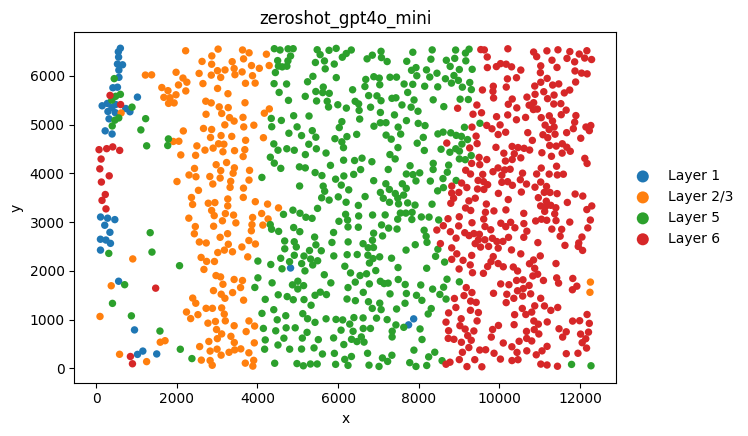

0.7458503624655395


In [41]:

adata.obs = adata.obs.join(gpt_results_df)
adata.obs['zeroshot_gpt4o_mini'] = adata.obs['zeroshot_gpt4o_mini'].fillna("unknown")
sc.pl.scatter(adata, x="x", y="y", color="zeroshot_gpt4o_mini", title =  f"zeroshot_gpt4o_mini")
print(adjusted_rand_score(adata.obs[config.name_truth], adata.obs['zeroshot_gpt4o_mini']))


In [ ]:
## refine the results using the neighbor matrix, this is optional
adata.obs['zeroshot_gpt4o_mini_refined'] = relabel_cells(adj_matrix.toarray(), adata.obs['zeroshot_gpt4o_mini'])
print(adjusted_rand_score(adata.obs[config.name_truth], adata.obs['zeroshot_gpt4o_mini_refined']))
#  save
adata.obs.to_csv(f"results/{config.data_name}_with_refined_{config.model_type}_{config.use_full_name}_{config.with_self_type}_{config.with_region_name}_{config.Graph_type}_{config.with_negatives}_{config.with_CoT}_{config.with_numbers}_{config.with_domain_name}{config.replicate}.csv")


# Gemini API


**Workflow:**
1. Generates prompts using the same `prompt_func` as the OpenAI pipeline
2. Sends prompts directly to Gemini model with specified generation config
3. Extracts results using the same parsing functions (`extract_output_microenvironments`)
4. Saves intermediate results as pickle files and CSV files in `./gemini_results/`

**Use Case**: Provides a synchronous alternative to OpenAI's asynchronous batch processing, useful for smaller datasets or when immediate results are needed, though potentially slower for large-scale processing due to sequential execution.


In [ ]:
# # use Gemini

genai.configure(api_key=os.environ["API_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
gen_config=genai.types.GenerationConfig(temperature=1.0, max_output_tokens=2000)

# %%
gemini_results_df, store_responses = run_gemini(model, gen_config, 
                                                neighbor_normalized_df, config, 
                                                prompt_func, n_rows=1, 
                                                df_extra=neighbor_normalized_df_genes,
                                                column_name="zeroshot_gemini")

# %%
with open(f'./gemini_results/{config.data_name}_{config.model_type}_{config.use_full_name}_{config.with_self_type}_{config.with_region_name}_{config.Graph_type}_{config.with_negatives}_{config.with_CoT}_{config.with_numbers}_{config.with_domain_name}_{config.confident_output}{config.replicate}.pkl', 'wb') as file:
    pickle.dump(store_responses, file)

gemini_results_df.to_csv(f"./gemini_results/{config.data_name}_results_df_{config.model_type}_{config.use_full_name}_{config.with_self_type}_{config.with_region_name}_{config.Graph_type}_{config.with_negatives}_{config.with_CoT}_{config.with_numbers}_{config.with_domain_name}_{config.confident_output}{config.replicate}.csv")


# %%
gemini_results_df.index = gemini_results_df.index.astype(str)

gemini_results_df.index.difference(adata.obs.index)

gemini_results_df.zeroshot_gemini.value_counts()

adata.obs = adata.obs.join(gemini_results_df)
adata.obs['zeroshot_gemini'] = adata.obs['zeroshot_gemini'].fillna("unknown")
sc.pl.scatter(adata, x="x", y="y", color="zeroshot_gemini", title =  f"zeroshot_gemini")
print(adjusted_rand_score(adata.obs[config.name_truth], adata.obs['zeroshot_gemini']))

adata.obs['zeroshot_gemini_refined'] = relabel_cells(adj_matrix.toarray(), adata.obs['zeroshot_gemini'])
print(adjusted_rand_score(adata.obs[config.name_truth], adata.obs['zeroshot_gemini_refined']))